# Multilingual intent classification using transformers

Hi! Glad to see you here.</br> </br>
We're going to solve a **multilingual text classification problem** in this coding tutorial.</br></br>

<p align="center">
    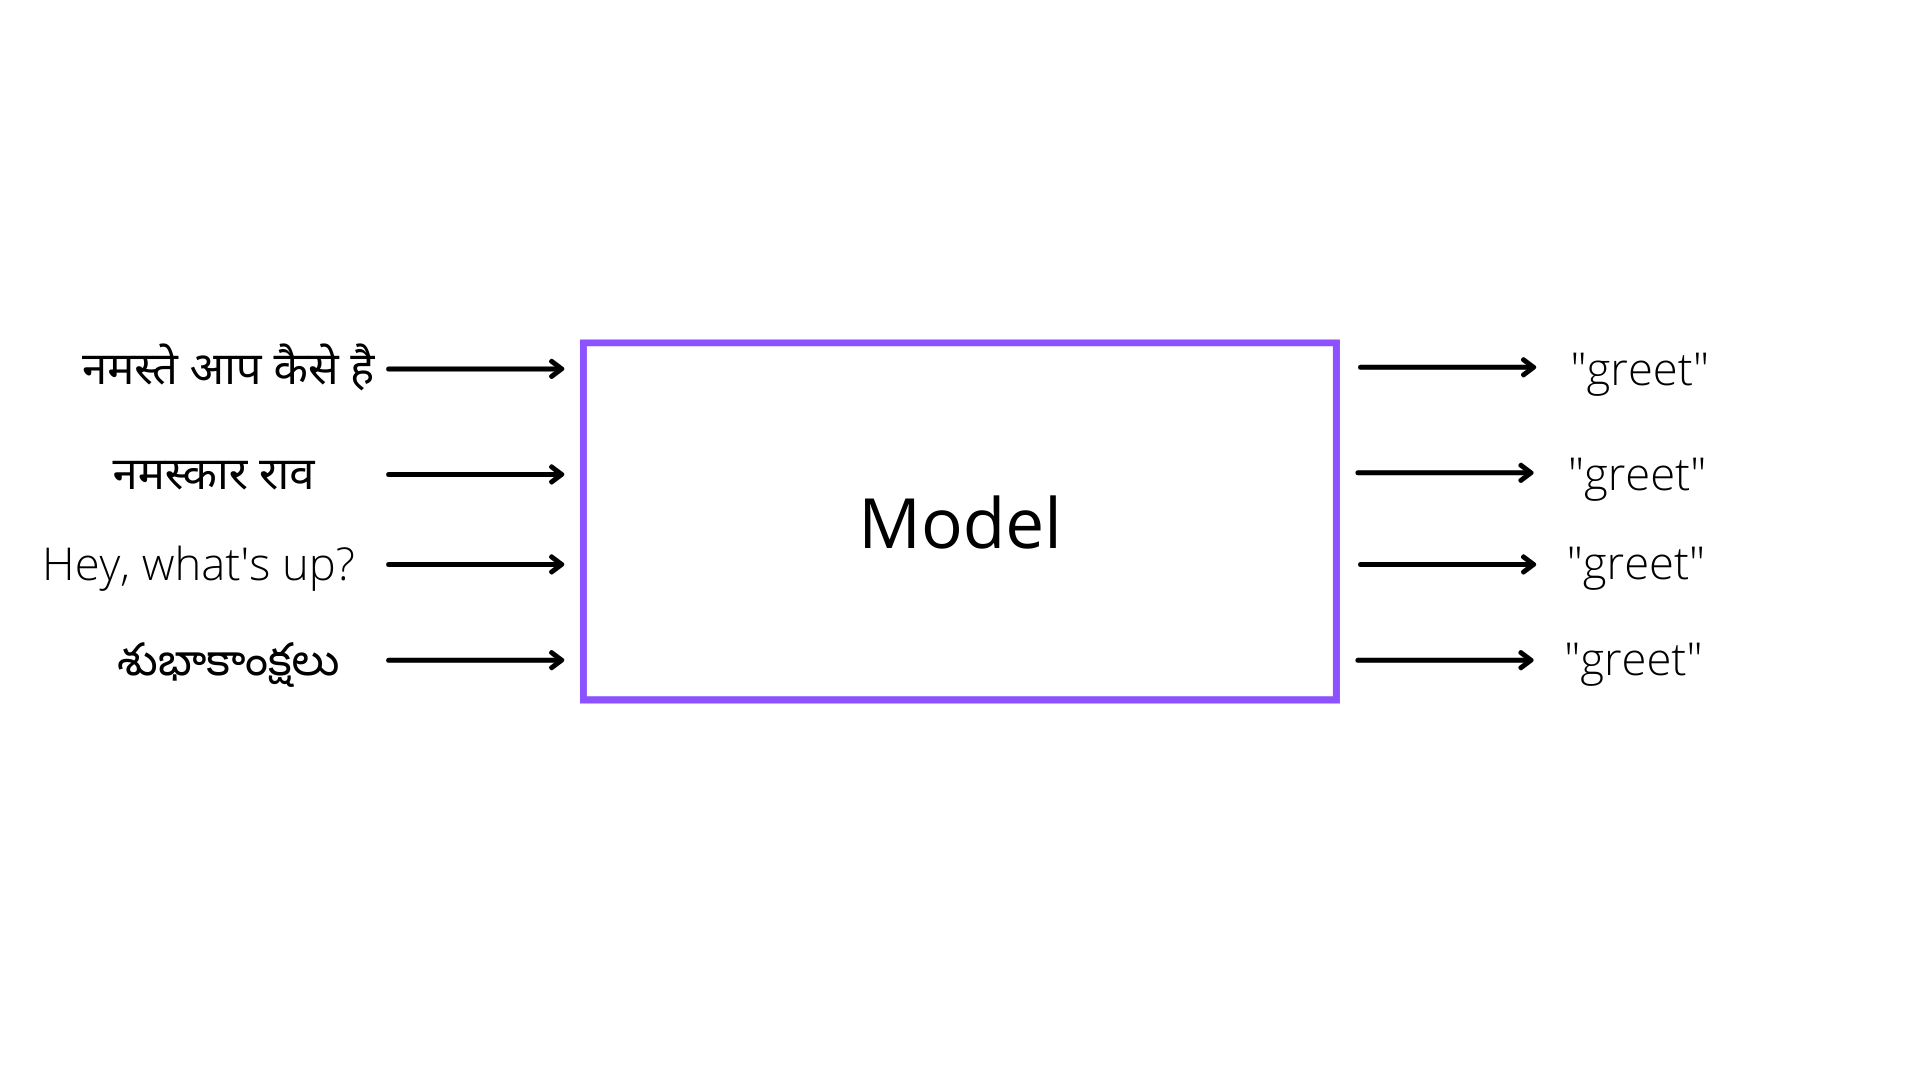
</p>

We use **Python** for coding, and **PyTorch** as our choice of deep learning framework for this tutorial. </br></br>

Let's get started.

## Pre-requisite installations


We start off by installing some python libraries that we will require to run our code.

To be specific, we install the `transformers` library from [Hugging Face](https://huggingface.co/), the `sentencepiece` library by Google, and the `lit_nlp` library.
`sentencepiece` is a dependency required for running the `transformers` library, and `lit_nlp` is used for visualizations later in the tutorial.

In [ ]:
!pip install transformers

In [ ]:
!pip install sentencepiece

In [ ]:
!pip install lit_nlp

## Imports

Now we move onto importing the libraries that we will require. </br></br>
The import statements are divided into three sections.</br>
1. General imports
2. PyTorch imports
3. Tensorboard (we use this for visualizing the training graphs)

In [ ]:
# General
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer

# Tensorboard
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

# Setting the seed to encourage reproducibility
torch.manual_seed(42)

## EDA

The first thing you're supposed to do when you get some data, is perform _exploratory data analysis_ on it. Without fail.</br>

We proceed to import the data in code by using a library called [pandas](https://pandas.pydata.org/docs/index.html). I've included resources to learn more about it at the end of this notebook if you're interested. </br>

Don't worry, you don't need to be an expert in `pandas`, we only use very basic functionality in this tutorial.

In [ ]:
train = pd.read_csv('train.csv')  # Reading the train.csv file into a DataFrame object.
label_list = list(set(train['label']))  # Extracting the list of labels from the DataFrame object.

In [ ]:
train.head()

In [ ]:
len(train)  # Getting the length of the training dataset

## Creating the Dataset class

Now that we've had a good look at the data, we can now start doing things in PyTorch. </br></br>

In order to pass this data to our models in PyTorch, we need to create a `Dataset` class and `DataLoaders` that help us batch the data samples together.</br></br>

The `Dataset` object will return preprocessed texts and the `DataLoader` object will combine these preprocessed texts together into one batch that we can feed to the model for training. </br></br>

<p align="center">
    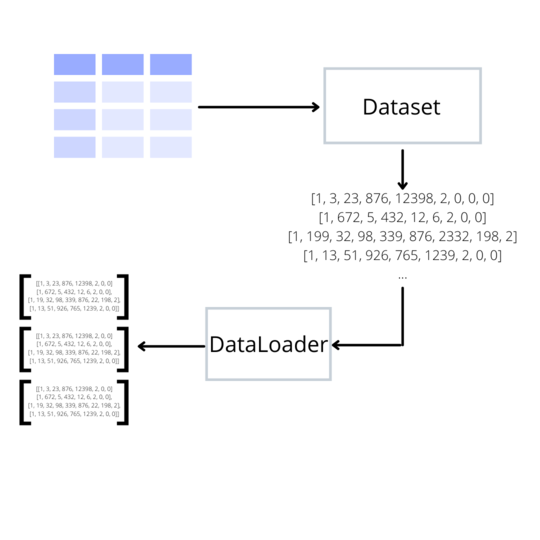
</p>

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, dataframe, label_list, max_seq_len):
        self.data = dataframe
        self.tokenizer = AutoTokenizer.from_pretrained('google/muril-base-cased')
        self.max_seq_len = max_seq_len
        self.label_list = label_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        label = self.data.iloc[idx]['label']
        indices = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_seq_len, return_tensors='pt')['input_ids']

        return {
            'model_input': indices,
            'label': self.label_list.index(label)
        }


def get_dataloaders(filepath, batch_size=32, max_seq_len=16):
    data = pd.read_csv(filepath)
    labels = list(set(data['label']))
    train, dev = train_test_split(data, test_size=0.1)

    train_dataset = ClassificationDataset(train, labels, max_seq_len)
    dev_dataset = ClassificationDataset(dev, labels, max_seq_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, dev_loader

In [ ]:
trainloader, devloader = get_dataloaders('train.csv')

## Building the model

For the model, we're going to use [Google's MuRIL](https://arxiv.org/abs/2103.10730). It's basically a BERT model with some additional modifications, that has been pre-trained on a huge corpora consisting solely of English and a bunch of Indian languages. </br></br>

[Hugging Face](https://huggingface.co/) has hosted the model on their platform that allows us to download and use it very conveniently using the `transformers` library.
Link to the model on their platform: [https://huggingface.co/google/muril-base-cased](https://huggingface.co/google/muril-base-cased)</br></br>

In general, whenever we use a pre-trained model, what we do is:</br>
1. Add new layers at the end to fit our use case.
2. Train the model on our data.

Here's how the generic model architecture will look like for simple transfer learning applications:</br></br>

<p align="center">
    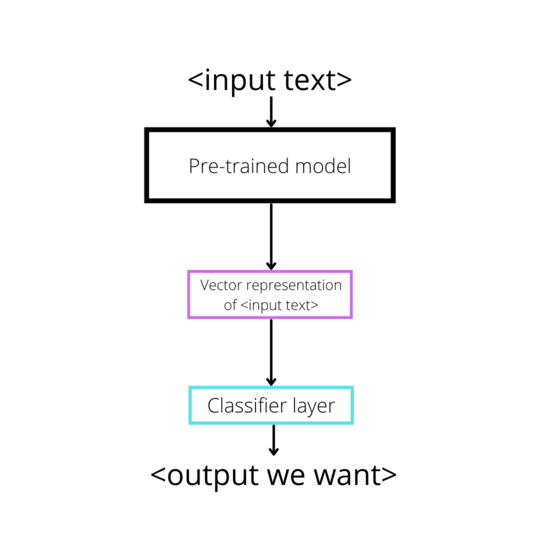
</p>

In [ ]:
class Classifier(nn.Module):
    def __init__(self, out_dim):
        super(Classifier, self).__init__()
        self.encoder = AutoModel.from_pretrained('google/muril-base-cased')
        self.output = nn.Linear(in_features=768, out_features=out_dim)

    def forward(self, x):
        x = self.encoder(x)[1]  # 1 stands for pooled output
        return self.output(x)

In [ ]:
out_dim = len(set(train['label']))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Classifier(out_dim).to(device)

## Training

Now that we've coded our model, we can finally start training it.

But before that, we have to define and initialize some more stuff (okay this is the last thing, I promise).</br></br>

Let's start off by defining the metric that we are going to use to evaluate how good our model is doing - **accuracy**.

Acccuracy is simply the ratio of correct predictions to the total number of predictions.

$$
\text{accuracy} = \frac{\text{number of correct predictions}}{\text{number of total predictions}}
$$

Intuitively speaking, if our model has a 70% accuracy, it means that our model is able to make the correct predictions 70% of the time (or it got 70 out of 100 predictions correct, if you're a fan of the frequentist interpretation of probability).

In [ ]:
def accuracy(y_pred, y_true):
    probs = torch.nn.functional.softmax(y_pred, dim=1)
    y_hat = np.argmax(probs.detach().cpu().numpy(), axis=1)

    acc = np.sum((y_hat == y_true).astype(int)) / len(y_true)

    return acc

After this, we need a loss function and an optimizer object to train the model. So we define those here.

There's another variable you see called `lr_scheduler`. It stands for "Learning Rate Scheduler".

In [ ]:
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=1435)

writer = SummaryWriter('runs/classifier_expt/')

In [ ]:
epochs = 36
losses = []
accs = []
n_iter = 0

for epoch in range(epochs):
    epoch_losses = []
    dev_losses = []
    epoch_accs = []
    dev_accs = []
    for batch in trainloader:
        opt.zero_grad()
        model.train()

        model_in = batch['model_input'].squeeze(1).to(device)
        labels = batch['label'].to(device)

        outs = model(model_in)

        loss = criterion(outs, labels)
        acc = accuracy(outs, labels.cpu().numpy())
        epoch_losses.append(loss.item())
        epoch_accs.append(acc)
        loss.backward()
        opt.step()
        lr_scheduler.step()
    
    for batch in devloader:
        with torch.no_grad():
            model.eval()
            model_in = batch['model_input'].squeeze(1).to(device)
            labels = batch['label'].to(device)

            outs = model(model_in)

            loss = criterion(outs, labels)
            acc = accuracy(outs, labels.cpu().numpy())
            dev_losses.append(loss.item())
            dev_accs.append(acc)
    
    mean_epoch_loss = np.mean(epoch_losses)
    mean_epoch_acc = np.mean(epoch_accs)
    val_loss = np.mean(dev_losses)
    val_acc = np.mean(dev_accs)
    
    writer.add_scalars('Loss', {'train': mean_epoch_loss, "val": val_loss}, epoch)
    writer.add_scalars('Accuracy', {'train': mean_epoch_acc, 'val': val_acc}, epoch)

    print(f'Epoch: {epoch}, Loss: {mean_epoch_loss}, Accuracy: {mean_epoch_acc}, Validation loss: {val_loss}, Validation accuracy: {val_acc}')


## Inference

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('google/muril-base-cased')

def inference(text, get_embedding=False):
    with torch.no_grad():
        model_in = tokenizer(text, padding='max_length', truncation=True, max_length=16, return_tensors='pt')['input_ids']
        model.eval()
        outs = model(model_in.to(device))

    if get_embedding:
        return outs

    probas = torch.nn.functional.softmax(outs, dim=1)
    probas = probas.cpu().numpy()[0]
    pred = label_list[np.argmax(probas)]

    return pred

In [ ]:
inference('ठीक आहे मी फोन ठेवते आता')

## Evaluation

In [ ]:
test = pd.read_csv('test.csv')

In [ ]:
preds = []

for text in test['text']:
    preds.append(inference(text))

In [ ]:
test['label_preds'] = preds

In [ ]:
acc = sum(test['label'] == test['label_preds']) / len(test)

In [ ]:
acc

## Visualization

In [ ]:
%tensorboard --logdir runs/classifier_expt/

In [ ]:
from lit_nlp import server_flags
from lit_nlp.dev_server import Server
from lit_nlp.api import model as lit_model
from lit_nlp.api import types as lit_types
from lit_nlp.api import dataset as lit_dataset
from lit_nlp import notebook

label_map = {label: idx for idx, label in enumerate(label_list)}

class LITDataset(lit_dataset.Dataset):

    LABELS = label_map

    def __init__(self, path):
        data = pd.read_csv(path)
        self._examples = [{
            'text': row['text'],
            'label': row['label'],
        } for _, row in data.iterrows()]

    def spec(self):
        return {
            'text': lit_types.TextSegment(),
            'label': lit_types.CategoryLabel(vocab=self.LABELS)
        }


class LITModel(lit_model.Model):

    LABELS = label_map
    def __init__(self):
        self._tokenizer = AutoTokenizer.from_pretrained('google/muril-base-cased')
        self._model = model

    def max_minibatch_size(self):
        return 32

    def predict_minibatch(self, inputs):
        res = []
        for sample in inputs:
            text = sample['text']
            res.append({'label': self.get_output(text), 'label_embedding': self.get_embedding(text)})
        return res
    
    def get_output(self, text):
        with torch.no_grad():
            model_in = self._tokenizer(text, padding='max_length', truncation=True, max_length=16, return_tensors='pt')['input_ids']
            self._model.eval()
            outs = self._model(model_in.to(device))

        probas = torch.nn.functional.softmax(outs, dim=1)
        probas = probas.cpu().numpy().tolist()

        return probas
    
    def get_embedding(self, text):
        with torch.no_grad():
            model_in = self._tokenizer(text, padding='max_length', truncation=True, max_length=16, return_tensors='pt')['input_ids']
            self._model.eval()
            outs = self._model(model_in.to(device))
        
        return outs.squeeze().cpu().numpy().tolist()


    def input_spec(self):
        return {
            'text': lit_types.TextSegment()
        }

    def output_spec(self):
        return {
            'label': lit_types.MulticlassPreds(vocab=self.LABELS, parent='label'),
            'label_embedding': lit_types.Embeddings(),
        }


datasets = {'train': LITDataset('train.csv')}
models = {'model': LITModel()}

widget = notebook.LitWidget(models, datasets, height=800)

In [ ]:
widget.render()

# Learn more about the topics presented today

1. [Andrew Ng's Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning)
2. [Practical Deep Learning for Coders by Fast.ai](https://course.fast.ai/)
3. [Natural Language Processing Specialization from deeplearning.ai](https://www.coursera.org/specializations/natural-language-processing)
4. [The Illustrated Transformer by Jay Alammar](https://jalammar.github.io/illustrated-transformer/)
5. [Understanding LSTMs by Chris Olah](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
6. [Hugging Face's transformers course](https://huggingface.co/course/chapter0/1?fw=pt)
7. [PyTorch course](https://www.youtube.com/watch?v=GIsg-ZUy0MY)
8. [Basics of PyTorch](https://pytorch.org/tutorials/beginner/basics/intro.html)